In [2]:
# Loading required packages: 

import pandas as pd
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re

ModuleNotFoundError: No module named 'torch'

In [4]:
# Reading the csv file:

news = pd.read_csv('/Users/samreade/Desktop/news_AP.csv')

In [5]:
# Previewing the data: 

news.head()

,title,topic
0,Terminally ill Connecticut woman ends her life...,Healthcare
1,King Charles III will have a prostate operatio...,Healthcare
2,Community health centers serve 1 in 11 America...,Healthcare
3,Washington state reaches a nearly $150 million...,Healthcare
4,Community health centers serve 1 in 11 America...,Healthcare


In [6]:
# Checking unique values for topic:

news['topic'].unique()

array(['Healthcare', 'Sports - Football', 'Animals', 'Transportation'],
      dtype=object)

In [7]:
# Making data frame for the 'title' column: 

titles = news['title']
titles 

0      Terminally ill Connecticut woman ends her life...
1      King Charles III will have a prostate operatio...
2      Community health centers serve 1 in 11 America...
3      Washington state reaches a nearly $150 million...
4      Community health centers serve 1 in 11 America...
                             ...                        
194    No joke: Feds discourage humorous electronic m...
195    A timeline of key moments leading to Japan pla...
196    Federal officials order grounding of some Boei...
197    What you should know if you're about to fly on...
198    Taylor Drift or Beyonsleigh? Voting open to na...
Name: title, Length: 199, dtype: object

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samreade/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Creating function for preprocessing: 

def preprocess_texts(texts):
    
    cleaned = [re.sub(r'[^\w\s]', '', t.lower()) for t in texts]

    tokenized = [[word for word in t.split() if word not in stop_words] for t in cleaned]

    all_words = [word for sublist in tokenized for word in sublist]
    word_counts = Counter(all_words)
    tokenized = [[word for word in tokens if word_counts[word] > 1] for tokens in tokenized]

    preprocessed_texts = [' '.join(tokens) for tokens in tokenized]
    return preprocessed_texts 


In [ ]:
preprocessed_titles = preprocess_texts(news['title'])   

In [16]:
# Vectorizing with tfidf:

vectorizer = TfidfVectorizer() 
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)

print(titles_tfidf.shape)  
print(titles_tfidf.toarray()) 

(199, 441)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.32230679 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [17]:
# Running kmeans for tfidf: 

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans.fit(titles_tfidf) 

KMeans(n_clusters=4, n_init=10, random_state=42)

In [18]:
news['tfidf_cluster'] = kmeans.labels_
news.head()

,title,topic,tfidf_cluster
0,Terminally ill Connecticut woman ends her life...,Healthcare,0
1,King Charles III will have a prostate operatio...,Healthcare,0
2,Community health centers serve 1 in 11 America...,Healthcare,0
3,Washington state reaches a nearly $150 million...,Healthcare,0
4,Community health centers serve 1 in 11 America...,Healthcare,0


In [19]:
news['topic_label'], topic_names = pd.factorize(news['topic'])
news.head()

,title,topic,tfidf_cluster,topic_label
0,Terminally ill Connecticut woman ends her life...,Healthcare,0,0
1,King Charles III will have a prostate operatio...,Healthcare,0,0
2,Community health centers serve 1 in 11 America...,Healthcare,0,0
3,Washington state reaches a nearly $150 million...,Healthcare,0,0
4,Community health centers serve 1 in 11 America...,Healthcare,0,0


In [20]:
# Creating Confusion Matrix: 

conf_matrix = confusion_matrix(news['topic_label'], news['tfidf_cluster'])

conf_df_tfidf = pd.DataFrame(
    conf_matrix,
    index=sorted(news['topic_label'].unique()),    
    columns=[f"Cluster {i}" for i in range(conf_matrix.shape[1])]
)

print(conf_df_tfidf)

   Cluster 0  Cluster 1  Cluster 2  Cluster 3
0         28          0          0          0
1         30         32          0         19
2         38          1          9          0
3         38          1          2          1


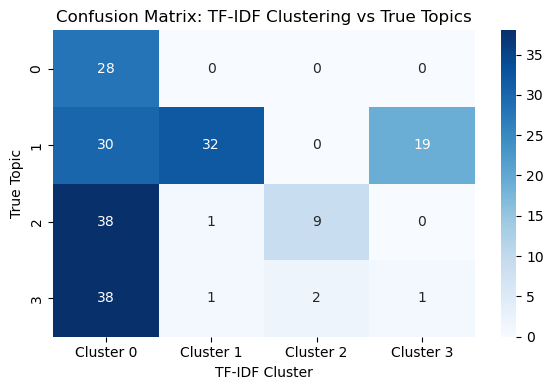

In [21]:
# Visualizing Confusion Matrix: 

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df_tfidf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: TF-IDF Clustering vs True Topics')
plt.xlabel('TF-IDF Cluster')
plt.ylabel('True Topic')
plt.tight_layout()
plt.show()

In [22]:
# Reporting precision, recall, F1-measure, and accuracy per topic for tfidf:  

true_tfidf = news['topic_label']
pred_tfidf = news['tfidf_cluster']

report = classification_report(true_tfidf, pred_tfidf, target_names=topic_names)
print("Classification Report:\n")
print(report)

accuracy = accuracy_score(true_tfidf, pred_tfidf)
print("Overall Accuracy:", round(accuracy, 4)) 


Classification Report:

                   precision    recall  f1-score   support

       Healthcare       0.21      1.00      0.35        28
Sports - Football       0.94      0.40      0.56        81
          Animals       0.82      0.19      0.31        48
   Transportation       0.05      0.02      0.03        42

         accuracy                           0.35       199
        macro avg       0.50      0.40      0.31       199
     weighted avg       0.62      0.35      0.36       199

Overall Accuracy: 0.3518


In [23]:
# Vectorizing with embeddings:

model = SentenceTransformer('all-MiniLM-L6-v2')

titles_embed = model.encode(titles)

print(titles_embed.shape)  
print(titles_embed[0])     

(199, 384)
[-2.44639833e-02 -1.43329110e-02  4.41281274e-02 -1.10135255e-02
  2.51884796e-02  5.03598414e-02 -7.07518011e-02  1.71091594e-02
 -1.03660794e-02  8.67259800e-02  2.92921793e-02  4.23028953e-02
 -4.44466174e-02 -5.34491539e-02 -4.92200777e-02  7.37725720e-02
 -9.33739990e-02 -2.32482720e-02 -1.35441395e-02  1.63757443e-01
  4.00544219e-02  4.77173813e-02  4.04412713e-04  2.37355996e-02
  2.61475239e-02  2.13943962e-02 -1.25460969e-02 -2.66241357e-02
  8.39642901e-03  6.66567534e-02 -4.21962179e-02  6.31326670e-03
 -3.34085822e-02 -7.14927586e-03  1.77836828e-02  1.13129308e-02
 -2.50684433e-02  5.97392768e-02 -6.91123679e-03  3.43728215e-02
 -3.33238370e-03  3.75055596e-02  4.93241511e-02  3.76770571e-02
 -2.55402271e-03 -7.81035796e-02 -4.44835573e-02 -3.14558558e-02
  1.63568594e-02  4.69642924e-03  2.34670565e-02 -3.61010456e-03
 -2.72163339e-02  5.90672567e-02  9.42404906e-04 -3.87796247e-03
  6.33248826e-03 -3.71260643e-02 -4.47440296e-02  1.98937692e-02
  2.01524571e-

In [24]:
# Running kmeans for embeddings: 

kmeans_embed = KMeans(n_clusters=4, n_init=10, random_state=43)
kmeans_embed.fit(titles_embed)

news['embed_cluster'] = kmeans_embed.labels_

In [25]:
# Creating Confusion Matrix: 

conf_matrix_embed = confusion_matrix(news['topic_label'], news['embed_cluster'])

conf_df_embed = pd.DataFrame(
    conf_matrix_embed,
    index=topic_names,
    columns=[f"Cluster {i}" for i in range(conf_matrix_embed.shape[1])]
)

print(conf_df_embed) 

                   Cluster 0  Cluster 1  Cluster 2  Cluster 3
Healthcare                 0          0          0         28
Sports - Football          1         77          0          3
Animals                   45          0          0          3
Transportation             0          1         37          4


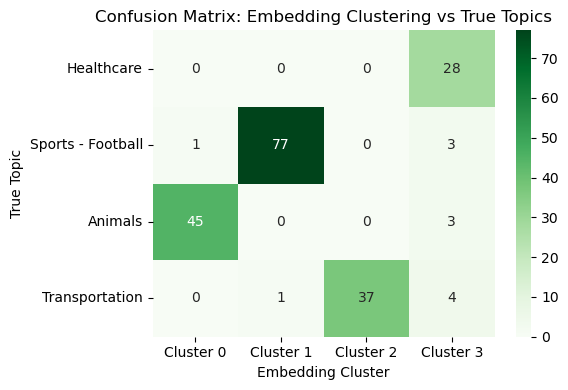

In [26]:
# Visualizing Confusion Matrix:

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df_embed, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: Embedding Clustering vs True Topics')
plt.xlabel('Embedding Cluster')
plt.ylabel('True Topic')
plt.tight_layout()
plt.show() 


In [27]:
# Reporting precision, recall, F1-measure, and accuracy per topic for embeddings: 

true_embed = news['topic_label']
pred_embed = news['embed_cluster']

# Detailed report
report = classification_report(true_embed, pred_embed, target_names=topic_names)
accuracy = accuracy_score(true_embed, pred_embed)

print("Classification Report (Embeddings):\n")
print(report)
print("Overall Accuracy (Embeddings):", round(accuracy, 4))


Classification Report (Embeddings):

                   precision    recall  f1-score   support

       Healthcare       0.00      0.00      0.00        28
Sports - Football       0.99      0.95      0.97        81
          Animals       0.00      0.00      0.00        48
   Transportation       0.11      0.10      0.10        42

         accuracy                           0.41       199
        macro avg       0.27      0.26      0.27       199
     weighted avg       0.42      0.41      0.42       199

Overall Accuracy (Embeddings): 0.407


In [ ]:
# Comparing the performance of tfidf and embeddings: 

# Embeddings were more effective with an accuracy of 40.7% compared to the tf_idf accuracy of 35.18%. 

# tf_idf had better recall with a score of 0.40 compared to the embeddings score of 0.26. 

# For precision tf_idf were better with a score of 0.50 compared to the embeddings score of  0.27. 

# For the F1-score embeddings were better again with a weighted average F1-score of 0.42 compared to 0.36 for tf_idf. 

# In conclusion embeddings performed better than tf_idf due to the higher accuracy and F1-score. 

In [28]:
# Trying with my own corpus: 

new_corpus = [
    
    # Tech 
    "Apple unveils new M3 chip for MacBooks",
    "AI startups are reshaping the job market",
    "Google introduces quantum computing breakthrough",
    "Amazon plans to build more data centers",
    "Meta launches new VR headset",
    "Elon Musk announces robotaxi rollout",
    "Microsoft invests in AI ethics lab",
    "Tesla updates autopilot features",

    # Politics 
    "Senate passes historic climate bill",
    "Elections spark debate over voting rights",
    "President addresses nation on economic recovery",
    "Supreme Court rules on gun control law",
    "Bipartisan deal reached on infrastructure",
    "Protests erupt over government surveillance",
    "Congress debates tax reform package",
    "New bill aims to regulate social media",

    # Health 
    "New study links sleep deprivation to heart disease",
    "COVID-19 booster shots recommended for fall",
    "Mental health crisis growing among teenagers",
    "Researchers develop universal flu vaccine",
    "Obesity rates rising in rural communities",
    "Breakthrough in cancer immunotherapy",
    "FDA approves new diabetes treatment",
    "Study finds benefits of Mediterranean diet",

    # Sports 
    "Lakers clinch playoff spot in dramatic finish",
    "World Cup qualifiers begin this weekend",
    "Serena Williams announces retirement from tennis",
    "NFL player suspended for betting violations",
    "Olympic Committee revises qualification rules",
    "Yankees win ninth straight game",
    "Soccer legend signs with MLS club",
    "NBA draft sees surprising top pick",

    # Environment
    "Wildfires spread rapidly across California",
    "UN summit tackles global water scarcity",
    "Coral reefs dying due to rising sea temps",
    "Scientists warn of Arctic ice loss",
    "EPA sets new air pollution limits",
    "Climate activists rally at state capitol",
    "New report highlights deforestation crisis",
    "Electric vehicles key to emissions targets"
]


In [29]:
new_labels = ["Tech"]*8 + ["Politics"]*8 + ["Health"]*8 + ["Sports"]*8 + ["Environment"]*8

In [30]:
embeddings = model.encode(new_corpus)

In [31]:
num_clusters = len(set(new_labels))
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=44)
predicted_clusters = kmeans.fit_predict(embeddings)

In [32]:
true_labels, label_names = pd.factorize(new_labels)

In [33]:
conf_matrix = confusion_matrix(true_labels, predicted_clusters)

conf_df = pd.DataFrame(
    conf_matrix,
    index=label_names,
    columns=[f"Cluster {i}" for i in range(conf_matrix.shape[1])]
)

print(conf_df) 

             Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
Tech                 0          1          0          7          0
Politics             0          0          4          0          4
Health               2          4          0          2          0
Sports               3          1          0          1          3
Environment          0          0          8          0          0


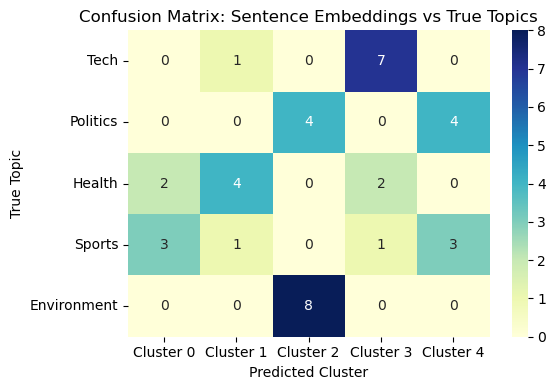

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix: Sentence Embeddings vs True Topics')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Topic')
plt.tight_layout()
plt.show() 

In [35]:
report = classification_report(true_labels, predicted_clusters, target_names=label_names)
accuracy = accuracy_score(true_labels, predicted_clusters)

print("Classification Report:\n")
print(report)
print("Overall Accuracy:", round(accuracy, 4))

Classification Report:

              precision    recall  f1-score   support

        Tech       0.00      0.00      0.00         8
    Politics       0.00      0.00      0.00         8
      Health       0.00      0.00      0.00         8
      Sports       0.10      0.12      0.11         8
 Environment       0.00      0.00      0.00         8

    accuracy                           0.03        40
   macro avg       0.02      0.03      0.02        40
weighted avg       0.02      0.03      0.02        40

Overall Accuracy: 0.025
